#Imports

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.autograd import Variable
import ast
import string
import random
import time, math

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline


In [3]:
file_name = 'metrolyrics.parquet'
lyrics_df_src = pd.read_parquet(file_name)
lyrics_df_src.head()

,song,year,artist,genre,lyrics,num_chars,sent,num_words
204182,fully-dressed,2008,annie,Pop,[HEALY]\n[spoken] This is Bert Healy saying .....,1041,healy spoken this bert healy saying singing he...,826
6116,surrounded-by-hoes,2006,50-cent,Hip-Hop,[Chorus: repeat 2X] Even when I'm tryin to be ...,1392,chorus repeat x even i tryin low i recognized ...,884
166369,taste-the-tears-thunderpuss-remix,2006,amber,Pop,How could you cause me so much pain?\nAnd leav...,1113,how could cause much pain and leave heart rain...,756
198416,the-truth-will-set-me-free,2006,glenn-hughes,Rock,In a scarlet vision\nIn a velvet room\nI come ...,779,in scarlet vision in velvet room i come decisi...,583
127800,the-last-goodbye,2008,aaron-pritchett,Country,Sprintime in Savannah\nIt dont get much pretti...,881,sprintime savannah it dont get much prettier b...,639


In [4]:
#load the data
lyrics_df = pd.read_csv('lyrics_df.csv')
lyrics_df.drop('Unnamed: 0', axis=1, inplace=True)
lyrics_df['lyrics_conv'] = lyrics_df['lyrics_conv'].apply(lambda x: ast.literal_eval(x))
lyrics_df.head()

,song,year,artist,genre,lyrics,num_chars,sent,num_words,lyrics_conv
0,fully-dressed,2008,annie,Pop,[HEALY]\n[spoken] This is Bert Healy saying .....,1041,healy spoken this bert healy saying singing he...,826,"[healy, spoken, bert, healy, saying, singing, ..."
1,surrounded-by-hoes,2006,50-cent,Hip-Hop,[Chorus: repeat 2X] Even when I'm tryin to be ...,1392,chorus repeat x even i tryin low i recognized ...,884,"[chorus, repeat, even, tryin, low, recognized,..."
2,taste-the-tears-thunderpuss-remix,2006,amber,Pop,How could you cause me so much pain?\nAnd leav...,1113,how could cause much pain and leave heart rain...,756,"[could, cause, much, pain, leave, heart, rain,..."
3,the-truth-will-set-me-free,2006,glenn-hughes,Rock,In a scarlet vision\nIn a velvet room\nI come ...,779,in scarlet vision in velvet room i come decisi...,583,"[scarlet, vision, velvet, room, come, decision..."
4,the-last-goodbye,2008,aaron-pritchett,Country,Sprintime in Savannah\nIt dont get much pretti...,881,sprintime savannah it dont get much prettier b...,639,"[sprintime, savannah, dont, get, much, prettie..."


In [5]:
lyrics_df[lyrics_df.genre == 'Rock']['lyrics'][:5]

3     In a scarlet vision\nIn a velvet room\nI come ...
23    your hands in the wind\nyour pretending to be ...
27    I put my voice away\nI shoot the lights out no...
32    Some days I barely hold on\nWhen life drags me...
35    Yea?????\nNowhere to go?No place to go...\nI?m...
Name: lyrics, dtype: object

In [6]:
s = lyrics_df[lyrics_df.genre == 'Rock']['lyrics'][:1]
print(s.values[0])

In a scarlet vision
In a velvet room
I come to my decision
On a dog day afternoon
I'm breaking my tradition
I think I realize
I walk on gilded splinters
I have shaken my disguise
I'm not looking for confrontation
I'm not looking for sympathy
I'm not looking for aggravation
The truth will set me free
I need somebody to push me
I need some gravity
I need to kiss the sun
The truth will set me free
Set me free
Take a trip to freedom
My wisdom is my guide
The world just keep turnin'
From the spirit deep inside
I can't be no saviour
I just wanna be
In my darkest
The truth will set me free
I'm not looking for moderation
I'm not looking for charity
I'm not looking for admiration
The truth will set me free
I need a good relation
I need a tibetan faith
The truth will set me free


In [7]:
text_clf_df = lyrics_df[['lyrics','lyrics_conv','genre','artist']]

#we decided to keep the \n in the lyrics, so we can use it to split the lyrics into sentences
text_clf_df['lyrics'] = text_clf_df['lyrics'].str.replace('\n', ' \n ')
text_clf_df

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,lyrics,lyrics_conv,genre,artist
0,[HEALY] \n [spoken] This is Bert Healy saying ...,"[healy, spoken, bert, healy, saying, singing, ...",Pop,annie
1,[Chorus: repeat 2X] Even when I'm tryin to be ...,"[chorus, repeat, even, tryin, low, recognized,...",Hip-Hop,50-cent
2,How could you cause me so much pain? \n And le...,"[could, cause, much, pain, leave, heart, rain,...",Pop,amber
3,In a scarlet vision \n In a velvet room \n I c...,"[scarlet, vision, velvet, room, come, decision...",Rock,glenn-hughes
4,Sprintime in Savannah \n It dont get much pret...,"[sprintime, savannah, dont, get, much, prettie...",Country,aaron-pritchett
...,...,...,...,...
49971,To all the men I knew before \n Old love lette...,"[men, knew, old, love, letters, drawer, mean, ...",Pop,bananarama
49972,Well it's a twenty-five mile drive from here t...,"[well, mile, drive, town, ther, gray, skies, d...",Rock,billy-ray-cyrus
49973,"Tu viens de partir pour de longs mois, c'est l...","[tu, viens, de, partir, pour, de, longs, mois,...",Pop,dalida
49974,"I'm still here, but yet I'm gone \n I don't pl...","[still, yet, gone, play, guitar, sing, songs, ...",Pop,glen-campbell


In [9]:
text_clf_df['lyrics_conv'] = text_clf_df['lyrics'].str.replace('\[.*\]',r' ')
text_clf_df['lyrics_conv'] = text_clf_df['lyrics_conv'].apply(lambda x: x.split(' '))
text_clf_df['lyrics_conv'] = list(filter(lambda a: a != ' ', text_clf_df['lyrics_conv']))
text_clf_df['lyrics_conv_str'] = text_clf_df['lyrics_conv'].apply(lambda x: ' '.join(map(str,x)))
text_clf_df#[['lyrics','lyrics_conv_str']]

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be

,lyrics,lyrics_conv,genre,artist,lyrics_conv_str
0,[HEALY] \n [spoken] This is Bert Healy saying ...,"[, , \n, , , This, is, Bert, Healy, saying, .....",Pop,annie,"\n This is Bert Healy saying ... \n Hey,..."
1,[Chorus: repeat 2X] Even when I'm tryin to be ...,"[, , 50, Cent, I'm, makin, hits, now, Don't, t...",Hip-Hop,50-cent,50 Cent I'm makin hits now Don't try an act ...
2,How could you cause me so much pain? \n And le...,"[How, could, you, cause, me, so, much, pain?, ...",Pop,amber,How could you cause me so much pain? \n And le...
3,In a scarlet vision \n In a velvet room \n I c...,"[In, a, scarlet, vision, \n, In, a, velvet, ro...",Rock,glenn-hughes,In a scarlet vision \n In a velvet room \n I c...
4,Sprintime in Savannah \n It dont get much pret...,"[Sprintime, in, Savannah, \n, It, dont, get, m...",Country,aaron-pritchett,Sprintime in Savannah \n It dont get much pret...
...,...,...,...,...,...
49971,To all the men I knew before \n Old love lette...,"[To, all, the, men, I, knew, before, \n, Old, ...",Pop,bananarama,To all the men I knew before \n Old love lette...
49972,Well it's a twenty-five mile drive from here t...,"[Well, it's, a, twenty-five, mile, drive, from...",Rock,billy-ray-cyrus,Well it's a twenty-five mile drive from here t...
49973,"Tu viens de partir pour de longs mois, c'est l...","[Tu, viens, de, partir, pour, de, longs, mois,...",Pop,dalida,"Tu viens de partir pour de longs mois, c'est l..."
49974,"I'm still here, but yet I'm gone \n I don't pl...","[I'm, still, here,, but, yet, I'm, gone, \n, I...",Pop,glen-campbell,"I'm still here, but yet I'm gone \n I don't pl..."


In [10]:
# let's see how many songs we have for each artist in Rock genre
songs = text_clf_df[text_clf_df['genre'] == 'Rock']
print(len(songs))
songs['artist'].value_counts()

11733


elton-john           68
david-bowie          67
bruce-springsteen    61
b-b-king             56
bob-dylan            55
                     ..
geoff-tate            1
euphoria              1
darling-parade        1
eddie-cochran         1
funambulista          1
Name: artist, Length: 2353, dtype: int64

In [11]:
song = text_clf_df[text_clf_df['genre'] == 'Rock'].iloc[0].values[0]
print(song)


In a scarlet vision 
 In a velvet room 
 I come to my decision 
 On a dog day afternoon 
 I'm breaking my tradition 
 I think I realize 
 I walk on gilded splinters 
 I have shaken my disguise 
 I'm not looking for confrontation 
 I'm not looking for sympathy 
 I'm not looking for aggravation 
 The truth will set me free 
 I need somebody to push me 
 I need some gravity 
 I need to kiss the sun 
 The truth will set me free 
 Set me free 
 Take a trip to freedom 
 My wisdom is my guide 
 The world just keep turnin' 
 From the spirit deep inside 
 I can't be no saviour 
 I just wanna be 
 In my darkest 
 The truth will set me free 
 I'm not looking for moderation 
 I'm not looking for charity 
 I'm not looking for admiration 
 The truth will set me free 
 I need a good relation 
 I need a tibetan faith 
 The truth will set me free


In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Data preparation

In [13]:
def random_chunk_from_genre(df, genre, artist, max_char=200):
    song = ''
    filtered_songs_df = df[(df['genre'] == genre) & \
            (df['artist'] == artist) & \
            (df['lyrics_conv_str'].str.len() >= max_char)].reset_index()
    songs_by_genre_amount = len(filtered_songs_df)
    rnd_song_idx = random.randint(0,songs_by_genre_amount-1)
    song = filtered_songs_df.iloc[rnd_song_idx]['lyrics_conv_str']
    return song

songs = random_chunk_from_genre(text_clf_df, 'Rock', 'elton-john')
print(song)

In a scarlet vision 
 In a velvet room 
 I come to my decision 
 On a dog day afternoon 
 I'm breaking my tradition 
 I think I realize 
 I walk on gilded splinters 
 I have shaken my disguise 
 I'm not looking for confrontation 
 I'm not looking for sympathy 
 I'm not looking for aggravation 
 The truth will set me free 
 I need somebody to push me 
 I need some gravity 
 I need to kiss the sun 
 The truth will set me free 
 Set me free 
 Take a trip to freedom 
 My wisdom is my guide 
 The world just keep turnin' 
 From the spirit deep inside 
 I can't be no saviour 
 I just wanna be 
 In my darkest 
 The truth will set me free 
 I'm not looking for moderation 
 I'm not looking for charity 
 I'm not looking for admiration 
 The truth will set me free 
 I need a good relation 
 I need a tibetan faith 
 The truth will set me free


In [14]:
# Turn string into list of longs
all_characters = string.printable
n_characters = len(all_characters)

def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        try:
            tensor[c] = all_characters.index(string[c])
        except:
#             print('error in substring', string[c])
            continue
    return Variable(tensor)

print(char_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41])


In [15]:
def random_training_set(df, genre, artist, chunk_len):    
    chunk = random_chunk_from_genre(df, genre, artist, chunk_len)
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

random_training_set(text_clf_df, 'Rock', 'elton-john', 200)

(tensor([44, 94, 15, 14, 21, 21, 94, 18, 23, 94, 21, 24, 31, 14, 94, 32, 18, 29,
         17, 94, 34, 24, 30, 94, 24, 23, 14, 94, 54, 14, 25, 29, 14, 22, 11, 14,
         27, 94, 96, 94, 37, 14, 29, 32, 14, 14, 23, 94, 29, 17, 14, 94, 10, 28,
         17, 14, 28, 94, 10, 23, 13, 94, 29, 17, 14, 94, 13, 34, 18, 23, 16, 94,
         14, 22, 11, 14, 27, 28, 94, 96, 94, 58, 17, 10, 29, 94, 17, 10, 25, 25,
         14, 23, 14, 13, 94, 29, 24, 94, 24, 30, 27, 94, 13, 27, 14, 10, 22, 28,
         94, 96, 94, 49, 24, 29, 17, 18, 23, 16, 94, 28, 24, 94, 18, 29, 94, 28,
         14, 14, 22, 28, 94, 96, 94, 37, 30, 29, 94, 44, 94, 15, 14, 21, 21, 94,
         18, 23, 94, 21, 24, 31, 14, 94, 32, 18, 29, 17, 94, 34, 24, 30, 94, 96,
         94, 53, 14, 22, 14, 22, 11, 14, 27, 94, 96, 94, 44, 15, 94, 29, 17, 14,
         94, 25, 17, 24, 23, 14, 94, 15, 24, 27, 16, 14, 29, 28, 94, 29, 24, 94,
         27, 18, 23, 16, 94, 29, 17, 18, 28, 94, 14, 31, 14, 23, 18, 23, 16, 94,
         96, 94, 36, 23, 13,

#Model

In [21]:
    
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1, drop_prob=0.2):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(
            input_size=hidden_size, 
            hidden_size=hidden_size, 
            num_layers=n_layers, 
            dropout=0.2,
#             bidirectional=True
        )
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        emb_input = self.encoder(input.view(1,-1))
        output, hidden = self.lstm(emb_input, hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return (Variable(torch.zeros(self.n_layers, 1, self.hidden_size)),
                Variable(torch.zeros(self.n_layers, 1, self.hidden_size)))

class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1, drop_prob=0.2):
        super(BiLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(
            input_size=hidden_size, 
            hidden_size=hidden_size, 
            num_layers=n_layers, 
            dropout=0.2,
            bidirectional=True
        )
        self.decoder = nn.Linear(hidden_size*2, output_size)
    
    def forward(self, input, hidden):
        emb_input = self.encoder(input.view(1,-1))
        output, hidden = self.lstm(emb_input, hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return (Variable(torch.zeros(self.n_layers*2, 1, self.hidden_size)),
                Variable(torch.zeros(self.n_layers*2, 1, self.hidden_size)))


#Model Evaluation

In [17]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    state_h, state_c = decoder.init_hidden()
    state_h = state_h.to(device)
    state_c = state_c.to(device)
    prime_input = char_tensor(prime_str)
    predicted = prime_str
    
    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, (state_h, state_c) = decoder(prime_input[p].to(device), (state_h, state_c))
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, (state_h, state_c) = decoder(inp.to(device), (state_h, state_c))
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

#Training

In [18]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [19]:
def train(inp, target):
    state_h, state_c = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0
    
    inp = inp.to(device)
    target = target.to(device)
    state_h = state_h.to(device)
    state_c = state_c.to(device)
    
    for c in range(chunk_len-1):
        output, (state_h, state_c) = decoder(inp[c], (state_h, state_c))
        loss += criterion(output, target[c].unsqueeze(0))

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / chunk_len

In [22]:
n_epochs = 4000
print_every = 400
plot_every = 10
hidden_size = 256
n_layers = 3
lr = 0.001
chunk_len = 300
genre = 'Rock'
artist = 'elton-john'

decoder = BiLSTM(n_characters, hidden_size, n_characters, n_layers).to(device)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set(text_clf_df, genre,artist,chunk_len))       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 52s (400 10%) 1.8844]
Whe wall I ving line enow 
 more suach 
 Lock 
 Toy you stance and I mees beted and Rey's hrine your b 

 48s (800 20%) 0.9297]
When you can between 
 And a camic a bak a left left can a can 
 the change 
 The girl in this little  

 37s (1200 30%) 0.7762]
When a crazy lide by left me. 
 They restless poing the wonderaming on the last in one light 
 Sould u 

 25s (1600 40%) 0.4545]
Whenever I'm again, no the ashes only gave me momenber 
 Living in my hays and cry.. 
 Between you fol 

 12s (2000 50%) 0.2165]
When I think of her 
 In takes me there us by a start 
 Oh sould hands fexplaing you't to with a fever 

 1s (2400 60%) 0.0936]
When I think of those east end lights, muggy nights 
 The clopzing in my heart 
 With this threw chain 

 49s (2800 70%) 0.0872]
When she gets up in the belly of the beast 
 And when you can't get on she the sun 
 And pime there's  

 37s (3200 80%) 0.0743]
When she gets up in the morning 
 It's enough to wake the dears 
 Just a cha

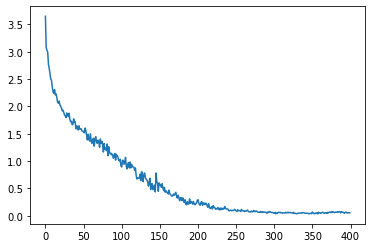

In [23]:
# plot the loss
plt.figure()
plt.plot(all_losses)

#Results

In [24]:
print(evaluate('Love ', 200, temperature=0.8))

Love loved is a candy and his town 
 To loke achen of the last can link up the blues 
 A heard of a complete 
 With the things you do 
 Something that she heard? 
 My by loves to love 
 Got a lot of dreams


In [25]:
print(evaluate('Space ', 200, temperature=0.8))

Space the sun 
 And picture postcards can't reveal all the things we've done 
 And the flowers will never die 
 And the flags we love 
 Beneath the fault-line truth to burn 
 Within the page so much to lear


In [ ]:
# we can see that the model was able to learn many things:
# 1. how word looks. it started from bunch of random letters and got to cohirent words.
# 2. how sentence of a song looks like. short sentences -> learn how to use the \n char 
# 3. somtimes it even rhymes